<a href="https://colab.research.google.com/github/Agrannya-Singh/Doom_Scroller_Instagram/blob/main/DoomScroller_Analizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#login into Instgram using intagraapi

from instagrapi import Client
from google.colab import userdata


# --- USER SETTINGS ---
# Replace with your actual Instagram credentials or use Colab secrets
# Remember to handle your credentials securely, e.g., using environment variables or Colab secrets
USERNAME = "jattman1993"
PASSWORD =userdata.get('password')

# ---------------------

cl = Client()

try:
    cl.login(USERNAME, PASSWORD)
    print(f"Successfully logged in as {USERNAME}")
except Exception as e:
    print(f"Error during instagrapi login: {e}")
    print("Please make sure your username and password are correct and that you can log in manually.")
    print("If prompted for a verification code, please enter it in the output below.")

Successfully logged in as jattman1993


In [10]:
#reels saver
import time
import random

# --- USER SETTINGS ---
COLLECTION_NAME = "Collab Reels"
TARGET_REELS_COUNT = 100  # Process up to this many reels
MIN_SAVES = 7
MAX_SAVES = 15
# ---------------------

# Placeholder for personality_profile (replace with your actual profile data if needed)
personality_profile = {} # Or define a dictionary with your personality traits

saved_reels = []
processed_reels = 0
candidate_reels = []  # Store reels with their scores for ranking

def personality_save_decision(reel, personality_profile):
    """
    Custom logic for INTJ-T personality based on your specific traits:
    - High: Inquisitiveness (90), Aesthetic Appreciation (97), Autonomy (97),
           Creativity (83), Intellectual Efficiency (67), Innovation (87)
    - Low: Sociability (3-7), Affiliation (13), Social boldness (43)
    """
    score = 0

    # Extract reel attributes safely
    tags = getattr(reel, 'tags', []) + getattr(reel, 'hashtags', [])
    desc = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
    desc_lower = desc.lower()

    # HIGH INQUISITIVENESS (90) - Knowledge, learning, exploration
    intellectual_keywords = ['science', 'research', 'explained', 'how', 'why', 'theory',
                           'analysis', 'study', 'facts', 'discovery', 'experiment',
                           'psychology', 'philosophy', 'history', 'technology']
    if any(word in desc_lower for word in intellectual_keywords):
        score += 3

    # HIGH AESTHETIC APPRECIATION (97) - Visual beauty, art, design
    aesthetic_keywords = ['aesthetic', 'art', 'design', 'beautiful', 'visual',
                         'cinematography', 'photography', 'architecture', 'minimal',
                         'composition', 'color', 'artistic']
    if any(word in desc_lower for word in aesthetic_keywords):
        score += 3

    # HIGH AUTONOMY (97) - Independence, self-reliance, unconventional
    autonomy_keywords = ['independent', 'solo', 'self', 'individual', 'unique',
                        'unconventional', 'different', 'original', 'personal']
    if any(word in desc_lower for word in autonomy_keywords):
        score += 2

    # HIGH CREATIVITY (83) & INNOVATION (87) - Creative content, new ideas
    creative_keywords = ['creative', 'innovative', 'invention', 'new', 'original',
                        'diy', 'build', 'create', 'design', 'craft', 'make']
    if any(word in desc_lower for word in creative_keywords):
        score += 2

    # HIGH INTELLECTUAL EFFICIENCY (67) - Concise, efficient information
    length = getattr(reel, 'video_duration', 0)
    if 10 <= length <= 45:  # Preference for medium-length, information-dense content
        score += 1

    # DEDUCT for LOW SOCIABILITY (3-7) - Avoid highly social content
    social_keywords = ['party', 'friends', 'group', 'social', 'together', 'crowd',
                      'everyone', 'people', 'community', 'team']
    if any(word in desc_lower for word in social_keywords):
        score -= 2

    # DEDUCT for LOW AFFILIATION (13) - Avoid relationship/emotional content
    emotional_keywords = ['relationship', 'love', 'heart', 'feelings', 'emotional',
                         'together', 'couple', 'romantic', 'cute', 'sweet']
    if any(word in desc_lower for word in emotional_keywords):
        score -= 2

    # BONUS for complexity and depth (matches INTJ preference)
    complex_keywords = ['complex', 'deep', 'detailed', 'comprehensive', 'advanced',
                       'expert', 'professional', 'technical', 'analysis']
    if any(word in desc_lower for word in complex_keywords):
        score += 1

    # BONUS for educational/tutorial content (high inquisitiveness)
    educational_keywords = ['tutorial', 'learn', 'guide', 'tip', 'hack', 'skill',
                           'knowledge', 'education', 'teach', 'lesson']
    if any(word in desc_lower for word in educational_keywords):
        score += 2

    return score

print("Processing 100 reels and applying personality-based selection...")

# Fetch explore reels
try:
    explore_reels = cl.explore_reels()
    print(f"Fetched {len(explore_reels)} explore reels.")
except Exception as e:
    print(f"Error fetching explore reels: {e}")
    explore_reels = [] # Initialize as empty list to avoid NameError later

# First pass: Score all reels
for reel in explore_reels[:TARGET_REELS_COUNT]:
    processed_reels += 1
    print(f"Analyzing Reel {processed_reels}/{TARGET_REELS_COUNT} (ID: {reel.id})...")

    score = personality_save_decision(reel, personality_profile)
    candidate_reels.append((reel, score))
    print(f"Score: {score}")

# Sort reels by score (highest first)
candidate_reels.sort(key=lambda x: x[1], reverse=True)

# Select top reels within the 7-15 range
print(f"\nSelecting reels to save (minimum {MIN_SAVES}, maximum {MAX_SAVES})...")

# Ensure we get at least MIN_SAVES reels
reels_to_save = min(MAX_SAVES, max(MIN_SAVES, len([r for r in candidate_reels if r[1] > 0])))

# If we don't have enough positive-scoring reels, take the top-scoring ones anyway
if len([r for r in candidate_reels if r[1] > 0]) < MIN_SAVES:
    reels_to_save = MIN_SAVES

selected_reels = candidate_reels[:reels_to_save]

print(f"Selected {len(selected_reels)} reels to save based on personality match.")

# --- SAVE SELECTED REELS TO COLLECTION ---

print(f"\nAttempting to save selected reels to the '{COLLECTION_NAME}' collection...")

try:
    print(f"Looking for existing collection: '{COLLECTION_NAME}'...")
    collections = cl.collections()
    collab_collection = next((c for c in collections if c.name == COLLECTION_NAME), None)

    if not collab_collection:
        print(f"Collection '{COLLECTION_NAME}' not found. Please create it manually on Instagram.")
        print("Skipping adding media to collection.")
    else:
        print(f"Using existing collection: {COLLECTION_NAME} (ID: {collab_collection.id})")

        for i, (reel, score) in enumerate(selected_reels, 1):
            try:
                # CORRECTED: Use media_save instead of collection_add_media
                cl.media_save(reel.id, collab_collection.id)
                print(f"Saved reel {i}/{len(selected_reels)} (ID: {reel.id}, Score: {score}) to '{COLLECTION_NAME}'.")
                saved_reels.append(reel.id)
                time.sleep(random.uniform(1, 2))  # Human-like delay
            except Exception as save_error:
                print(f"Could not save reel {reel.id} to collection: {save_error}")

except Exception as e:
    print(f"An error occurred during collection management: {e}")

print(f"\nProcessing complete!")
print(f"Total reels analyzed: {processed_reels}")
print(f"Total reels saved to collection: {len(saved_reels)}")
print(f"Saved reels: {saved_reels}")

Processing 100 reels and applying personality-based selection...
Fetched 10 explore reels.
Analyzing Reel 1/100 (ID: 3662134177216259058_73901491628)...
Score: 0
Analyzing Reel 2/100 (ID: 3649275160120309436_64703355772)...
Score: 1
Analyzing Reel 3/100 (ID: 3647708429135219905_74996099567)...
Score: 1
Analyzing Reel 4/100 (ID: 3661305151730419580_74829121084)...
Score: 1
Analyzing Reel 5/100 (ID: 3661562890869692956_70339477089)...
Score: 4
Analyzing Reel 6/100 (ID: 3596378784200721531_61221585315)...
Score: 1
Analyzing Reel 7/100 (ID: 3656188996830676738_71478687552)...
Score: 0
Analyzing Reel 8/100 (ID: 3660403760326938347_53789360284)...
Score: 1
Analyzing Reel 9/100 (ID: 3587235477495027432_57311022889)...
Score: 6
Analyzing Reel 10/100 (ID: 3662134540459833537_73901491628)...
Score: 0

Selecting reels to save (minimum 7, maximum 15)...
Selected 7 reels to save based on personality match.

Attempting to save selected reels to the 'Collab Reels' collection...
Looking for existing c

In [12]:
!pip install instagrapi transformers torch matplotlib --quiet


In [13]:
from instagrapi import Client
from transformers import pipeline
import matplotlib.pyplot as plt


In [14]:
# reel fething function ( calls 10 reels from the fyp page)
try:
    explore_reels = cl.explore_reels()
    print(f"Fetched {len(explore_reels)} explore reels.")
except Exception as e:
    print(f"Error fetching explore reels for analysis: {e}")
    explore_reels = []


Fetched 10 explore reels.


In [15]:
#reels sentiment classifer
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import emoji
import re
from collections import Counter

# Load multilingual models
emotion_model = pipeline(
    "text-classification",
    model="finiteautomata/bertweet-base-emotion-analysis"
)

sentiment_model = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

# Hindi/English model
hindi_model_name = "ai4bharat/indic-bert"
hindi_tokenizer = AutoTokenizer.from_pretrained(hindi_model_name)
hindi_model = AutoModelForSequenceClassification.from_pretrained(hindi_model_name)

# Emotion to category mapping with enhanced granularity
emotion_map = {
    # Positive
    "joy": "positive",
    "love": "positive",
    "happy": "positive",
    "excitement": "positive",
    "surprise": "positive",
    "pride": "positive",
    "gratitude": "positive",
    "hope": "positive",
    # Negative
    "anger": "negative",
    "sadness": "negative",
    "fear": "negative",
    "hate": "negative",
    "disgust": "negative",
    "shame": "negative",
    "guilt": "negative",
    "jealousy": "negative",
    # Neutral
    "neutral": "neutral",
    "empty": "neutral",
    "boredom": "neutral"
}

neutral_keywords = {
    "ad", "sponsored", "promo", "sale", "discount",
    "offer", "shop now", "linkinbio", "advertisement",
    # Hindi neutral keywords
    "विज्ञापन", "प्रचार", "ऑफर", "डिस्काउंट", "बिक्री"
}

hindi_latin_keywords = {
    "vigyapan", "prachar", "offer", "discount", "bikri"
}

def preprocess_text(text):
    """Enhanced text cleaning with Hindi support"""
    if not text:
        return ""

    # Convert emojis to text
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Remove URLs and mentions
    text = re.sub(r"http\S+|@\w+", "", text)

    # Expand common abbreviations (English and Hinglish)
    abbrevs = {
        r"\bomg\b": "oh my god",
        r"\btbh\b": "to be honest",
        r"\blol\b": "laughing out loud",
        r"\bfomo\b": "fear of missing out",
        r"\bky\b": "kyun",  # Hindi 'why' in Latin script
        r"\bkb\b": "kab",   # Hindi 'when' in Latin script
        r"\bmtlb\b": "matlab"  # Hindi 'meaning'
    }
    for pattern, replacement in abbrevs.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

    return text.strip()

def detect_language(text):
    """Simple language detection based on script"""
    if re.search(r"[\u0900-\u097F]", text):  # Devanagari characters
        return "hi"
    elif any(word in text.lower() for word in hindi_latin_keywords):
        return "hi-latin"
    else:
        return "en"

def analyze_hindi_content(text):
    """Analyze Hindi text using Indic-BERT"""
    try:
        inputs = hindi_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        outputs = hindi_model(**inputs)
        predictions = outputs.logits.softmax(dim=1)

        # Simple mapping - you may need to adjust based on your model's labels
        if predictions[0][2] > 0.5:  # Assuming index 2 is positive
            return "positive", float(predictions[0][2])
        elif predictions[0][0] > 0.5:  # Assuming index 0 is negative
            return "negative", float(predictions[0][0])
        else:
            return "neutral", float(predictions[0][1])  # Assuming index 1 is neutral
    except Exception as e:
        print(f"Hindi analysis error: {str(e)}")
        return "neutral", 0.5

def analyze_content(text):
    """Enhanced analysis with language detection and fallback mechanisms"""
    processed = preprocess_text(text)

    # Check for neutral content first
    text_lower = processed.lower()
    if (any(word in text_lower for word in neutral_keywords) or
        any(word in text_lower for word in hindi_latin_keywords)):
        return "neutral", 1.0, {"reason": "neutral_keyword"}

    # Detect language
    lang = detect_language(processed)

    try:
        if lang in ("hi", "hi-latin"):
            # Use Hindi model
            category, confidence = analyze_hindi_content(processed[:512])
            return category, confidence, {"language": lang, "model": "indic-bert"}
        else:
            # Original English analysis pipeline
            emotion_result = emotion_model(processed[:512])[0]
            emotion_label = emotion_result['label'].lower()
            emotion_score = emotion_result['score']

            sentiment_result = sentiment_model(processed[:512])[0]
            sentiment_label = sentiment_result['label'].lower()
            sentiment_score = sentiment_result['score']

            # Enhanced conflict resolution
            if sentiment_label == "positive" and emotion_map.get(emotion_label) == "negative":
                if sentiment_score > 0.85:  # Slightly more conservative threshold
                    return "positive", sentiment_score, {
                        "emotion": emotion_label,
                        "sentiment": sentiment_label,
                        "note": "high-confidence sentiment override"
                    }

            # More sophisticated scoring
            if emotion_score > 0.7:  # High confidence in emotion
                category = emotion_map.get(emotion_label, "neutral")
                confidence = emotion_score
            else:
                # Blend emotion and sentiment
                blended_score = (emotion_score * 0.6 + sentiment_score * 0.4)
                if sentiment_label == "positive" and blended_score > 0.6:
                    category = "positive"
                elif sentiment_label == "negative" and blended_score > 0.6:
                    category = "negative"
                else:
                    category = "neutral"
                confidence = blended_score

            return category, confidence, {
                "emotion": emotion_label,
                "sentiment": sentiment_label,
                "language": lang
            }

    except Exception as e:
        print(f"⚠️ Analysis error: {str(e)}")
        return "neutral", 0.5, {"error": str(e)}

def analyze_reels(reels, max_to_analyze=100):
    """Main analysis function with neutral feedback mechanism"""
    results = Counter({
        "positive": 0,
        "neutral": 0,
        "negative": 0
    })
    detailed_results = []

    if not reels:
        print("No reels to analyze.")
        return results, detailed_results

    for idx, reel in enumerate(reels[:max_to_analyze], 1):
        caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''

        category, confidence, details = analyze_content(caption)
        results[category] += 1

        detailed_results.append({
            "caption": caption,
            "category": category,
            "confidence": confidence,
            "details": details
        })

        # Print results
        lang_flag = "🇮🇳" if details.get("language", "en") != "en" else "🇬🇧"
        print(f"\n🎬 Reel {idx} {lang_flag}: [{category.upper()}] ({confidence:.0%})")
        print(f"📝 {caption[:100]}{'...' if len(caption) > 100 else ''}")
        if "emotion" in details:
            print(f"🔍 Emotion: {details['emotion']} | Sentiment: {details['sentiment']}")

    # Negative feedback mechanism for excessive neutrals
    total = sum(results.values())
    neutral_percentage = results["neutral"] / total

    if neutral_percentage > 0.33:  # 33% threshold
        print("\n⚠️ WARNING: High percentage of neutral reels detected!")
        print("Activating negative feedback mechanism...")

        # Re-analyze neutral reels with more aggressive parameters
        for result in detailed_results:
            if result["category"] == "neutral" and result["confidence"] < 0.7:
                # Re-analyze with different approach
                new_category, new_conf, new_details = reanalyze_neutral(
                    result["caption"],
                    result["confidence"]
                )
                if new_category != "neutral":
                    results["neutral"] -= 1
                    results[new_category] += 1
                    result.update({
                        "category": new_category,
                        "confidence": new_conf,
                        "details": new_details,
                        "reanalyzed": True
                    })

    # Final summary
    print("\n📊 Final Results:")
    for cat, count in results.items():
        print(f"- {cat.capitalize()}: {count} ({count/total:.0%})")

    return results, detailed_results

def reanalyze_neutral(text, original_confidence):
    """More aggressive analysis for neutral content"""
    processed = preprocess_text(text)

    # Try emotion model first with lower confidence threshold
    try:
        emotion_result = emotion_model(processed[:512])[0]
        if emotion_result['score'] > 0.5:  # Lower threshold
            mapped = emotion_map.get(emotion_result['label'].lower(), "neutral")
            if mapped != "neutral":
                return mapped, emotion_result['score'], {
                    "emotion": emotion_result['label'].lower(),
                    "note": "reanalyzed with lower threshold"
                }
    except:
        pass

    # Try looking for strong positive/negative keywords
    positive_keywords = {"great", "awesome", "amazing", "best", "love", "बहुत अच्छा", "शानदार"}
    negative_keywords = {"bad", "worst", "hate", "disappointed", "खराब", "बेकार"}

    text_lower = processed.lower()
    pos_count = sum(1 for word in positive_keywords if word in text_lower)
    neg_count = sum(1 for word in negative_keywords if word in text_lower)

    if pos_count > neg_count and pos_count >= 1:
        return "positive", min(0.7, original_confidence + 0.2), {
            "note": f"positive keywords found ({pos_count})"
        }
    elif neg_count > pos_count and neg_count >= 1:
        return "negative", min(0.7, original_confidence + 0.2), {
            "note": f"negative keywords found ({neg_count})"
        }

    # Fallback to original result
    return "neutral", original_confidence, {
        "note": "no strong signals found in reanalysis"
    }

# Run analysis
emotion_counts, detailed_results = analyze_reels(explore_reels)

Device set to use cpu
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream 


🎬 Reel 1 🇬🇧: [NEUTRAL] (98%)
📝 🙂
#indianpolitics #politics #trending #bjp #narendramodi #bjpindia #reels
🔍 Emotion: others | Sentiment: neutral

🎬 Reel 2 🇬🇧: [NEUTRAL] (100%)
📝 Suprise Raid At PW VPRP🤯

🎬 Reel 3 🇬🇧: [NEUTRAL] (98%)
📝 Real 💔🤣
#viral 
#explore 
#reelsinstagram 
#comedy
🔍 Emotion: others | Sentiment: negative

🎬 Reel 4 🇬🇧: [NEUTRAL] (95%)
📝 Okay that's all.
🔍 Emotion: others | Sentiment: neutral

🎬 Reel 5 🇬🇧: [NEUTRAL] (45%)
📝 
🔍 Emotion: others | Sentiment: positive

🎬 Reel 6 🇬🇧: [NEUTRAL] (97%)
📝 Bohut achi khushbu aati hai
🔍 Emotion: others | Sentiment: neutral

🎬 Reel 7 🇬🇧: [NEUTRAL] (96%)
📝 Mappila Ramayan of Muslims of Kerala ! One of 100’s of Ramayan retellings .
🔍 Emotion: others | Sentiment: neutral

🎬 Reel 8 🇬🇧: [NEUTRAL] (45%)
📝 
🔍 Emotion: others | Sentiment: positive

🎬 Reel 9 🇬🇧: [POSITIVE] (72%)
📝 Kumbhalgarh breathes with the spirit of valor and pride of Rajasthan. Its massive wall stretches ove...
🔍 Emotion: joy | Sentiment: positive

🎬 Reel 10 🇬🇧: [NEUT

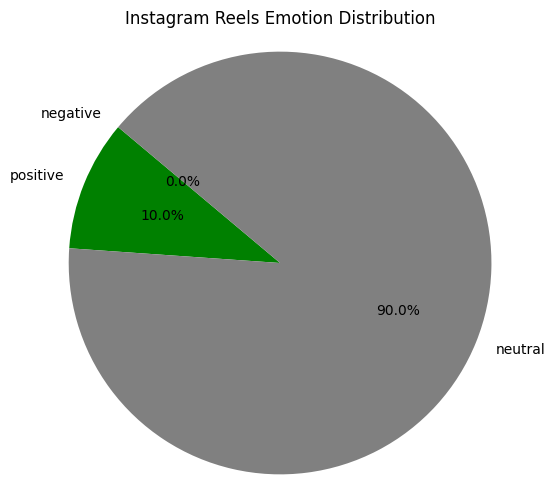

In [16]:
#pie chart plotter for reels emotion
if sum(emotion_counts.values()) == 0:
    print("No data to plot. No reels were classified into positive, neutral, or negative categories.")
else:
    labels = list(emotion_counts.keys())
    sizes = [emotion_counts[l] for l in labels]
    colors = ['green', 'grey', 'red']

    plt.figure(figsize=(6,6))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
    plt.title('Instagram Reels Emotion Distribution')
    plt.axis('equal')
    plt.show()


Device set to use cpu


⏳ Analyzing reels...

✅ Analysis complete!

📊 Category Counts:
- Other: 3
- News: 2
- Technology: 2
- Comedy: 1
- Meme: 1
- Movie: 1


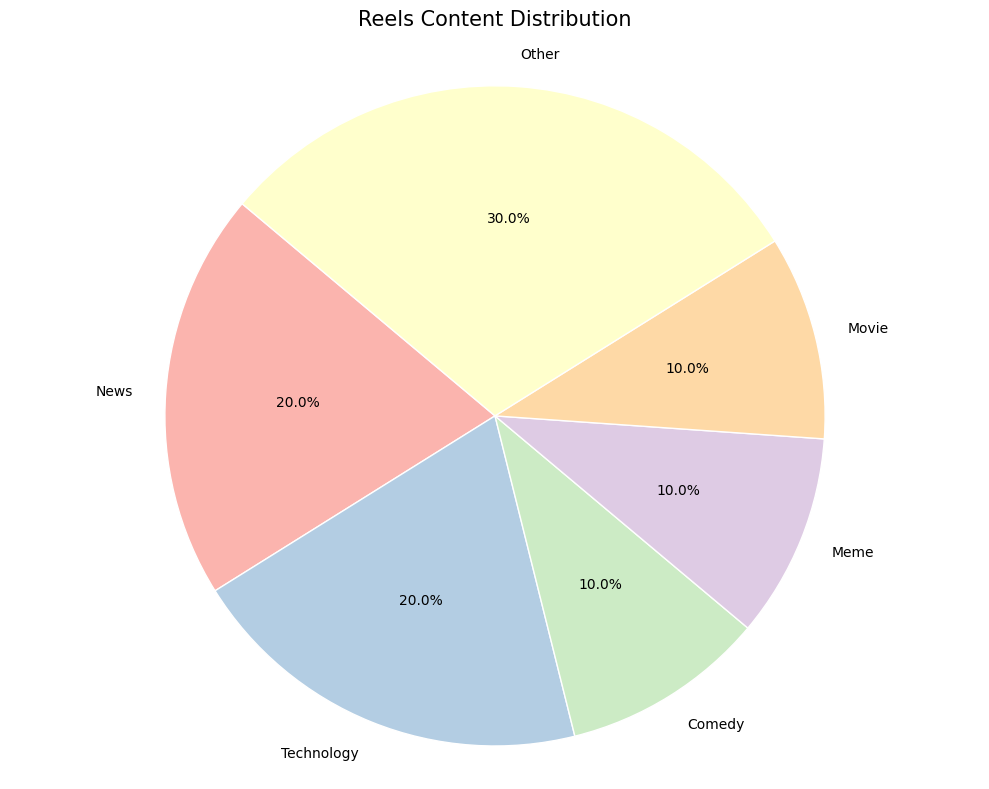

In [17]:
# Reels Content
from transformers import pipeline
import re
from collections import Counter
import matplotlib.pyplot as plt

# Load classification model
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

# Content categories
content_categories = [
    "news",
    "meme",
    "sports",
    "science",
    "music",
    "movie",
    "gym",
    "comedy",
    "food",
    "technology"
]

# Keyword shortcuts
category_keywords = {
    "news": {"news", "update", "breaking", "reported"},
    "meme": {"meme", "funny", "lol", "haha"},
    "sports": {"sports", "cricket", "football", "match"},
    "science": {"science", "research", "discovery"},
    "music": {"music", "song", "album", "release"},
    "movie": {"movie", "film", "bollywood", "trailer"},
    "gym": {"gym", "workout", "fitness"},
    "comedy": {"comedy", "joke", "humor"},
    "food": {"food", "recipe", "cooking"},
    "technology": {"tech", "phone", "computer", "ai"}
}

def preprocess_text(text):
    """Basic text cleaning"""
    return re.sub(r"http\S+|@\w+", "", text.lower()).strip() if text else ""

def classify_reel(text):
    """Fast classification"""
    processed = preprocess_text(text)

    # Keyword matching
    for category, keywords in category_keywords.items():
        if any(keyword in processed for keyword in keywords):
            return category

    # Model classification
    if len(processed.split()) >= 3:
        try:
            result = classifier(processed[:512], content_categories)
            return result['labels'][0]
        except:
            pass

    return "other"

def plot_category_distribution(counter, title="Reels Content Distribution"):
    """Generate pie chart from category counts"""
    # Prepare data
    labels = []
    sizes = []

    # Separate larger categories from others
    threshold = sum(counter.values()) * 0.05  # 5% threshold
    other_count = 0

    for category, count in counter.most_common():
        if count >= threshold and category != "other":
            labels.append(category.title())
            sizes.append(count)
        else:
            other_count += count

    if other_count > 0:
        labels.append("Other")
        sizes.append(other_count)

    # Create pie chart
    plt.figure(figsize=(10, 8))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Pastel1.colors,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    plt.title(title, pad=20, fontsize=15)
    plt.axis('equal')  # Equal aspect ratio ensures pie is circular
    plt.tight_layout()
    plt.show()

def analyze_and_visualize(reels, max_to_analyze=100):
    """Complete analysis with visualization"""
    category_counts = Counter()

    print("⏳ Analyzing reels...")
    for reel in reels[:max_to_analyze]:
        caption = getattr(reel, 'caption_text', '') or getattr(reel, 'caption', '') or ''
        category = classify_reel(caption)
        category_counts[category] += 1

    print("\n✅ Analysis complete!")
    print("\n📊 Category Counts:")
    for category, count in category_counts.most_common():
        print(f"- {category.title()}: {count}")

    # Generate visualization
    plot_category_distribution(category_counts)

    return category_counts

# Usage
results = analyze_and_visualize(explore_reels)